In [6]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os

# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from a_carbon_math import carbon_flux
from a_model_cutting_functions import CAFE60_eqpac_cutter, cut_regrid_reynolds_sst,cut_process_sst_obs_trends,proc_landschutzer,process_co2_land_trends

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#Attempting a plotting function
def mean_trends_82_20(lmean,ltrend82,ltrend20,rmean,rtrend82,rtrend20,titles,ltrendmm=None,rtrendmm=None,ltrendm=None,rtrendm=None,l_conversion=1,r_conversion=1,meancolormap='bwr',figsize=(20,10)):
    '''
    lmean     xrarr
    ltrend82  xrarr
    ltrend82p xarr
    ltrend20  xrarr
    ltrend20p pval xarr
    
    rmean     xrarr
    rtrend82  xrarr
    rtrend82p pval xarr
    rtrend20  xrarr 
    rtrend20p pval xarr
    titles    array[1,2,3,4,5,6]
    l_conversion float
    r_conversion float
    meancolormap     str cmap (ie viridis)
    
    Will dynamically produce a 3 x 2 (6) subplot with mean on top and 82 and 2000 trends below. 
    Can produce for any trend variable (produce mean over time, need a flag for this?)
    
    '''
    
    plt.figure(figsize=figsize)
    plt.subplot(321)
    if type(ltrendm)==type(None):
        (lmean.mean(dim='time')*l_conversion).plot(cmap=meancolormap) 
    else:
        (lmean.mean(dim='time')*l_conversion).plot(vmin=ltrendm[1],vmax=ltrendm[0],cmap=meancolormap)
    plt.title(titles[0])
    #(((cafe_co2_mean.stf10.mean(dim='time')/1000)*86400)*-12)
    #plt.title('CAFE ens mean mean CO2 flux out of ocean (gC m2 day)')

    plt.subplot(322)
    if type(ltrendm)==type(None):
        (rmean.mean(dim='time')*r_conversion).plot(cmap=meancolormap) 
    else:
        (rmean.mean(dim='time')*r_conversion).plot(vmin=rtrendm[1],vmax=rtrendm[0],cmap=meancolormap)
    plt.title(titles[1])
    #(land_obs.fgco2_smoothed/365).mean(dim='time').plot(vmin=-0.15,vmax=0.15,cmap='bwr')
    #plt.title('Lanschutzer mean CO2 flux out of ocean (gC m2 day)')

    plt.subplot(323)
    if type(ltrendmm)==type(None):
        (ltrend82*l_conversion).plot(cmap='bwr')
    else:
        (ltrend82*l_conversion).plot(vmax=ltrendmm[1],vmin=ltrendmm[0],cmap='bwr')
    plt.title(titles[2])
    #((((cafe_co2_82tr.trend/1000)*86400)*-12*1000)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
    #plt.title('CAFE CO2 flux longterm trends 1982-2020  (mgC/m2/day/year)')
    #plt.contourf(cafe_co2_82tr.pval.lon,cafe_co2_82tr.pval.lat,cafe_co2_82tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
 


    plt.subplot(324)
    if type(rtrendmm)==type(None):
        (rtrend82*r_conversion).plot(cmap='bwr')
    
    else:
        (rtrend82*r_conversion).plot(vmax=rtrendmm[1],vmin=rtrendmm[0],cmap='bwr')
    plt.title(titles[3])
    #((land_obs_tr_1982.trend)*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
    #plt.title('Landshutzer CO2 flux longterm trends 1982-2020  (mgC/m2/day/year)')
    #plt.contourf(land_obs_tr_1982.pval.lon,land_obs_tr_1982.pval.lat,land_obs_tr_1982.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   


    plt.subplot(325)
    if type(ltrendmm)==type(None):
        (ltrend20*l_conversion).plot(cmap='bwr')
    else:
        (ltrend20*l_conversion).plot(vmax=ltrendmm[1],vmin=ltrendmm[0],cmap='bwr')
    plt.title(titles[4])
    #((((cafe_co2_20tr.trend/1000)*86400)*-12*1000)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
    #plt.title('CAFE CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
    #plt.contourf(cafe_co2_20tr.pval.lon,cafe_co2_20tr.pval.lat,cafe_co2_20tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
    #plt.tight_layout()


    plt.subplot(326)
    if type(rtrendmm)==type(None):
        (rtrend20*r_conversion).plot(cmap='bwr')
    else:
        (rtrend20*r_conversion).plot(vmax=rtrendmm[1],vmin=rtrendmm[0],cmap='bwr')
    plt.title(titles[5])
    #((land_obs_tr_2000.trend)*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
    #plt.title('Landshutzer CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
    #plt.contourf(land_obs_tr_2000.pval.lon,land_obs_tr_2000.pval.lat,land_obs_tr_2000.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
    plt.tight_layout()
    plt.show()

### Reminder for units

In [8]:
d=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip',consolidated=True)
for i in d.variables:
    if len(i)<8:
        t='\t\t'
    else:#if len(i)<13:
        t='\t'
    try:
        print(i+t+d[i].units)
    except:
        print(i+t+'no units')

adic		mmol/m^3
alk		mmol/m^3
caco3		mmol/m^3
caco3_sediment	mmolN/m^2
det		mmol/m^3
det_sediment	mmolN/m^2
dic		mmol/m^3
ensemble	no units
export_inorg	mmolC/m^2/s
export_prod	mmolN/m^2/s
fe		mmol/m^3
no3		mmol/m^3
o2		mmol/m^3
paco2		
pco2		
phy		mmol/m^3
pprod_gross	mmolN/m^3/s
pprod_gross_2d	mmolN/m^2/s
scalar_axis	none
st_ocean	meters
stf03		mmol/m^2/s
stf07		mmol/m^2/s
stf10		mmol/m^2/s
surface_adic	mmol/m^3
surface_alk	mmol/m^3
surface_caco3	mmol/m^3
surface_det	mmol/m^3
surface_dic	mmol/m^3
surface_fe	mmol/m^3
surface_no3	mmol/m^3
surface_o2	mmol/m^3
surface_phy	mmol/m^3
surface_zoo	mmol/m^3
time		no units
total_aco2_flux	Pg/yr
total_co2_flux	Pg/yr
xt_ocean	degrees_E
yt_ocean	degrees_N
zoo		mmol/m^3


## Load our data in

In [9]:
'/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip'
'/g/data/xv83/np1383/processed_data/cafe/global/sst_ensmean_1982.'



'/g/data/xv83/np1383/processed_data/cafe/global/sst_ensmean_1982.'

In [10]:
cafe_co2_all=(((xr.open_dataset('../processed_data/eqpac/stf10_all_1982.nc')/1000)*86400)*-12)#g/m2/day
cafe_sst_all=xr.open_dataset('../processed_data/eqpac/sst_all_1982.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/g/data4/xv83/np1383/processed_data/eqpac/stf10_all_1982.nc'

In [24]:
ls ../processed_data/cafe/eqpac/


export_prod_ensmean_1982.nc        stf10_meantrends_1982.nc
export_prod_ensstd_1982.nc         stf10_meantrends_2000.nc
export_prod_meantrends_1982.nc     surface_dic_ensmean_1982.nc
export_prod_meantrends_2000.nc     surface_dic_ensstd_1982.nc
phy_ensmean_1982_15m_.nc           surface_dic_meantrends_1982.nc
phy_ensstd_1982_15m_.nc            surface_dic_meantrends_2000.nc
phy_meantrends_1982_15m_.nc        surface_zoo_ensmean_1982.nc
phy_meantrends_2000_15m_.nc        surface_zoo_ensstd_1982.nc
pprod_gross_2d_ensmean_1982.nc     surface_zoo_meantrends_1982.nc
pprod_gross_2d_ensstd_1982.nc      surface_zoo_meantrends_2000.nc
pprod_gross_2d_meantrends_1982.nc  u_ref_ensmean_1982.nc
pprod_gross_2d_meantrends_2000.nc  u_ref_meantrends_1982.nc
sst_ensmean_1982.nc                u_ref_meantrends_2000.nc
sst_ensstd_1982.nc                 v_ref_ensmean_1982.nc
sst_meantrends_1982.nc             v_ref_meantrends_1982.nc
sst_meantrends_2000.nc             v_ref_meantrends_2000.nc
stf10_ensmea

In [39]:
ls ../processed_data/obs

sst.mnmean.regrid.eqpac.nc  sst.mnmean.regrid.global.nc


In [29]:
xr.open_dataset('../processed_data/cafe/eqpac/phy_ensmean_1982_15m_.nc')

<xarray.Dataset>
Dimensions:   (time: 456, lon: 170, lat: 98)
Coordinates:
    st_ocean  float64 ...
  * time      (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
Data variables:
    phy       (time, lat, lon) float32 ...

In [40]:
#Bring all the unit conversions here. 

phy_mean=xr.open_dataset('../processed_data/cafe/eqpac/phy_ensmean_1982_15m_.nc')
#phy_std=xr.open_dataset('../processed_data/eqpac/surface_phy_ensstd_1982.nc')
phy_trend82=xr.open_dataset('../processed_data/cafe/eqpac/phy_meantrends_1982_15m_.nc')
phy_trend20=xr.open_dataset('../processed_data/cafe/eqpac/phy_meantrends_2000_15m_.nc')

#pprod_std=xr.open_dataset('../processed_data/eqpac/pprod_gross_2d_ensstd../_1982.nc')
pprod_mean=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_ensmean_1982.nc')
pprod_trend82=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_meantrends_1982.nc')
pprod_trend20=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_meantrends_2000.nc')


#LOAD CAFE SST AND CO2 FLUX
cafe_sst_std=xr.open_dataset('../processed_data/cafe/global/sst_ensstd_1982.nc')
cafe_sst_mean=xr.open_dataset('../processed_data/cafe/global/sst_ensmean_1982.nc')
cafe_sst_82tr=xr.open_dataset('../processed_data/cafe/global/sst_meantrends_1982.nc')
cafe_sst_20tr=xr.open_dataset('../processed_data/cafe/global/sst_meantrends_2000.nc')


cafe_co2_std=xr.open_dataset('../processed_data/cafe/global/stf10_ensstd_1982.nc')
cafe_co2_mean=xr.open_dataset('../processed_data/cafe/global/stf10_ensmean_1982.nc')
cafe_co2_82tr=xr.open_dataset('../processed_data/cafe/global/stf10_meantrends_1982.nc')
cafe_co2_20tr=xr.open_dataset('../processed_data/cafe/global/stf10_meantrends_2000.nc')


#Load CO2 and SST OBS PRODUCTS
#land_co2=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365 #g/m2/day
#land_co2_82tr=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid_trend_1982.nc')
#land_co2_20tr=xr.open_dataset('/../processed_data/obs/landshutzer_global_regrid_trend_2000.nc')

rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc')
#rey_sst_82tr=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.trend.1982.nc')
#rey_sst_20tr=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.trend.2000.nc')

## Phytoplankton test in progress

In [42]:
phy_mean

<xarray.Dataset>
Dimensions:   (time: 456, lon: 170, lat: 98)
Coordinates:
    st_ocean  float64 ...
  * time      (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
Data variables:
    phy       (time, lat, lon) float32 ...

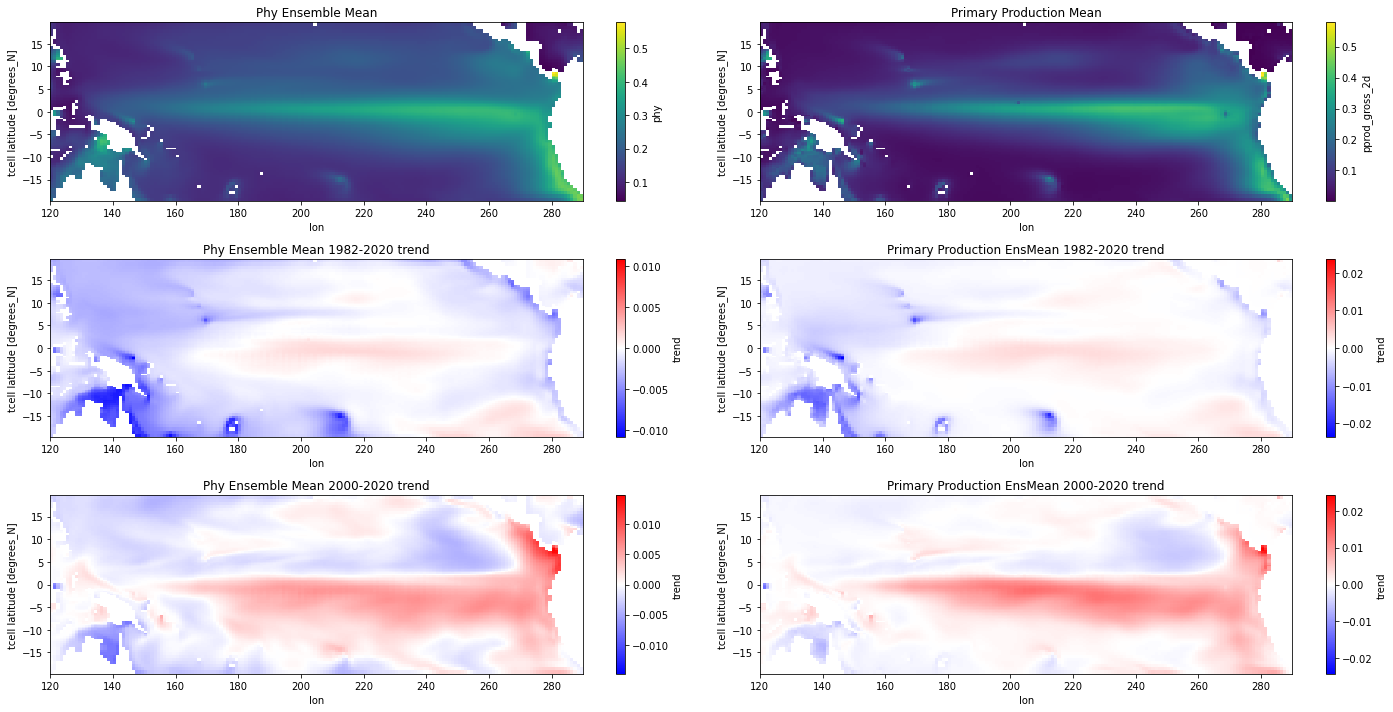

In [43]:
#Test the plotting function. Not super easy to use to be honest. 
titles=[
    'Phy Ensemble Mean',
    'Primary Production Mean',
    'Phy Ensemble Mean 1982-2020 trend',
    'Primary Production EnsMean 1982-2020 trend',
    'Phy Ensemble Mean 2000-2020 trend',
    'Primary Production EnsMean 2000-2020 trend']



mean_trends_82_20(lmean=phy_mean.phy,
                  ltrend82=phy_trend82.trend,
                  ltrend20=phy_trend20.trend,
                  rmean=pprod_mean.pprod_gross_2d,
                  rtrend82=pprod_trend82.trend,
                  rtrend20=pprod_trend20.trend,
                  titles=titles,
                  ltrendmm=None,
                  rtrendmm=None,
                  ltrendm=None,
                  rtrendm=None,
                  l_conversion=1,
                  r_conversion=6.625*12*86400/1000,
                  meancolormap='viridis',
                  figsize=(20,10))

## Lets look at and compare model CO2 flux to Landshutzer (spatial)

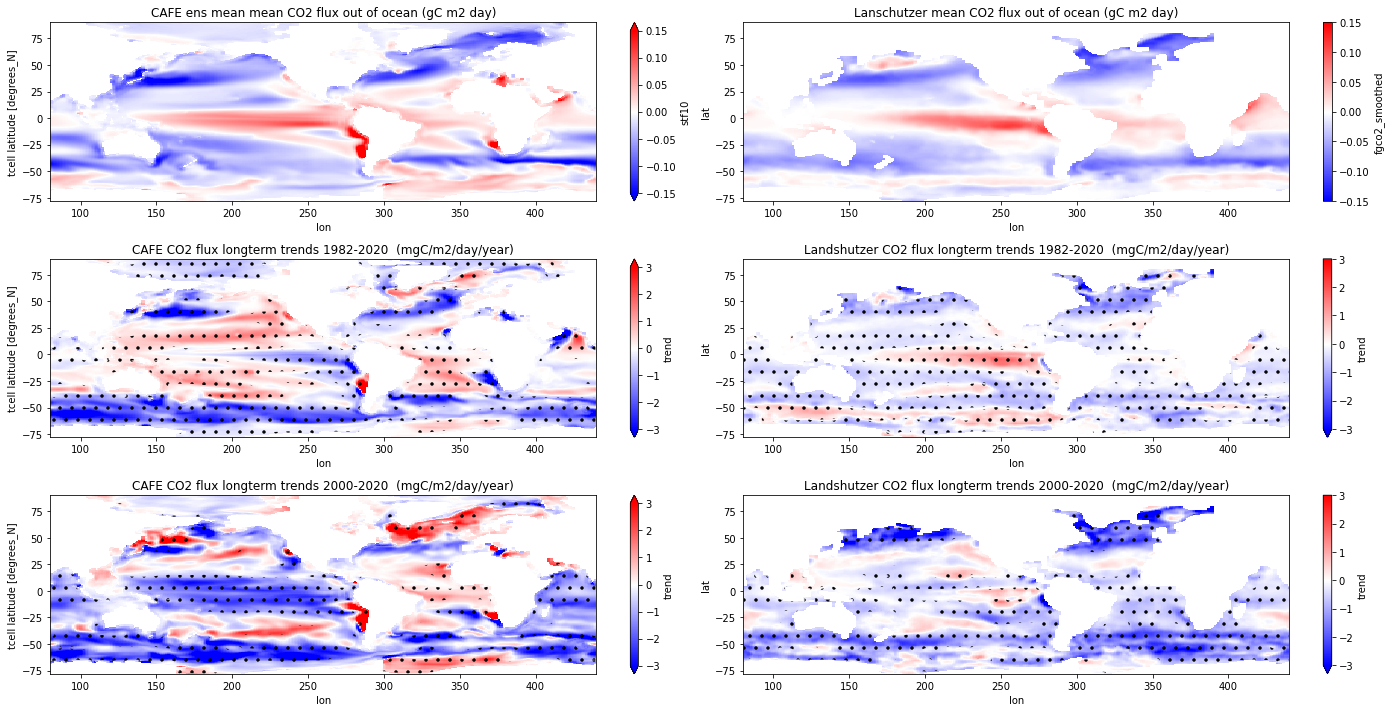

In [149]:
#CO2 FLUX mean and trends
plt.figure(figsize=(20,10))
plt.subplot(321)

(((cafe_co2_mean.stf10.mean(dim='time')/1000)*86400)*-12).plot(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('CAFE ens mean mean CO2 flux out of ocean (gC m2 day)')

plt.subplot(322)
(land_co2.fgco2_smoothed).mean(dim='time').plot(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('Lanschutzer mean CO2 flux out of ocean (gC m2 day)')

plt.subplot(323)
((((cafe_co2_82tr.trend/1000)*86400)*-12*1000)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('CAFE CO2 flux longterm trends 1982-2020  (mgC/m2/day/year)')
plt.contourf(cafe_co2_82tr.pval.lon,cafe_co2_82tr.pval.lat,cafe_co2_82tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


plt.subplot(324)
((land_co2_82tr.trend)*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('Landshutzer CO2 flux longterm trends 1982-2020  (mgC/m2/day/year)')
plt.contourf(land_co2_82tr.pval.lon,land_co2_82tr.pval.lat,land_co2_82tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


plt.subplot(325)
((((cafe_co2_20tr.trend/1000)*86400)*-12*1000)).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('CAFE CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
plt.contourf(cafe_co2_20tr.pval.lon,cafe_co2_20tr.pval.lat,cafe_co2_20tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   
plt.tight_layout()


plt.subplot(326)
((land_co2_20tr.trend)*1000).plot(vmax=3,vmin=-3,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
plt.title('Landshutzer CO2 flux longterm trends 2000-2020  (mgC/m2/day/year)')
plt.contourf(land_co2_20tr.pval.lon,land_co2_20tr.pval.lat,land_co2_20tr.pval.values,colors='none',hatches=['.'],levels=[0,0.05])   


plt.tight_layout()



Text(0, 0.5, 'lat')

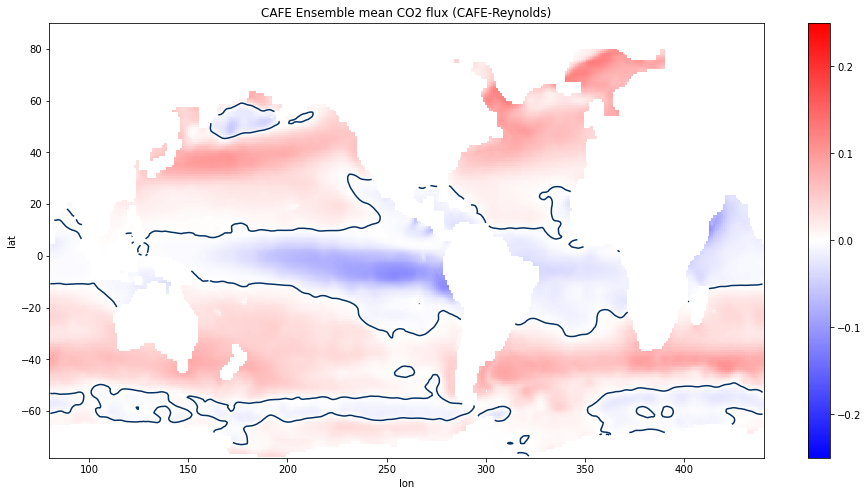

In [157]:
#Look at the difference between ensemble 1 and landschutzer
plt.figure(figsize=(16,8))
((cafe_co2_mean.stf10.mean(dim='time'))-land_co2.fgco2_smoothed.mean(dim='time')).plot(vmin=-0.25,vmax=0.25,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
((cafe_co2_mean.stf10.mean(dim='time'))-land_co2.fgco2_smoothed.mean(dim='time')).plot.contour(levels=[0])
                                                                                                 
plt.title('CAFE Ensemble mean CO2 flux (CAFE-Landschutzer)')
plt.ylabel('lat')

#plt.subplot(212)
#(sst_cafe.mean(dim=['time','ensemble'])-sst_obs.mean(dim='time')).plot(vmin=-1.5,vmax=1.5,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
#(sst_cafe.mean(dim=['time','ensemble'])-sst_obs.mean(dim='time')).plot.contour(levels=[0])
#plt.title('Mean CAFE SST anomoly (CAFE-Reynolds)')
#plt.ylabel('Lat')
#plt.tight_layout()

## Lets look at and compare model CO2 flux to Landshutzer (temporal)

cafe Co2 flux: 0.022411992866889417
land co2 flux: 0.028903054138014892
Whole EqPac : -17.8286516642985% err
cafe Co2 flux: 0.047760275030057225
land co2 flux: 0.06976458238986694
SouthEast EqPac : -21.37465213848831% err
cafe Co2 flux: 0.014236568198916121
land co2 flux: 0.016801987690276132
NorthEast EqPac : -19.734110382334382% err
cafe Co2 flux: 0.03099842161448667
land co2 flux: 0.043283285040071534
All East EqPac : -17.211551842081576% err
cafe Co2 flux: 0.027685718180518855
land co2 flux: 0.03421978466709998
Central EqPac : -9.861949124898471% err
cafe Co2 flux: 0.020130387883496553
land co2 flux: 0.017361798570402293
Dateline EqPac : -2.8297158845944614% err
cafe Co2 flux: 0.005361506035280114
land co2 flux: 0.003753222843304966
FarWest EqPac : -377.29769808868815% err


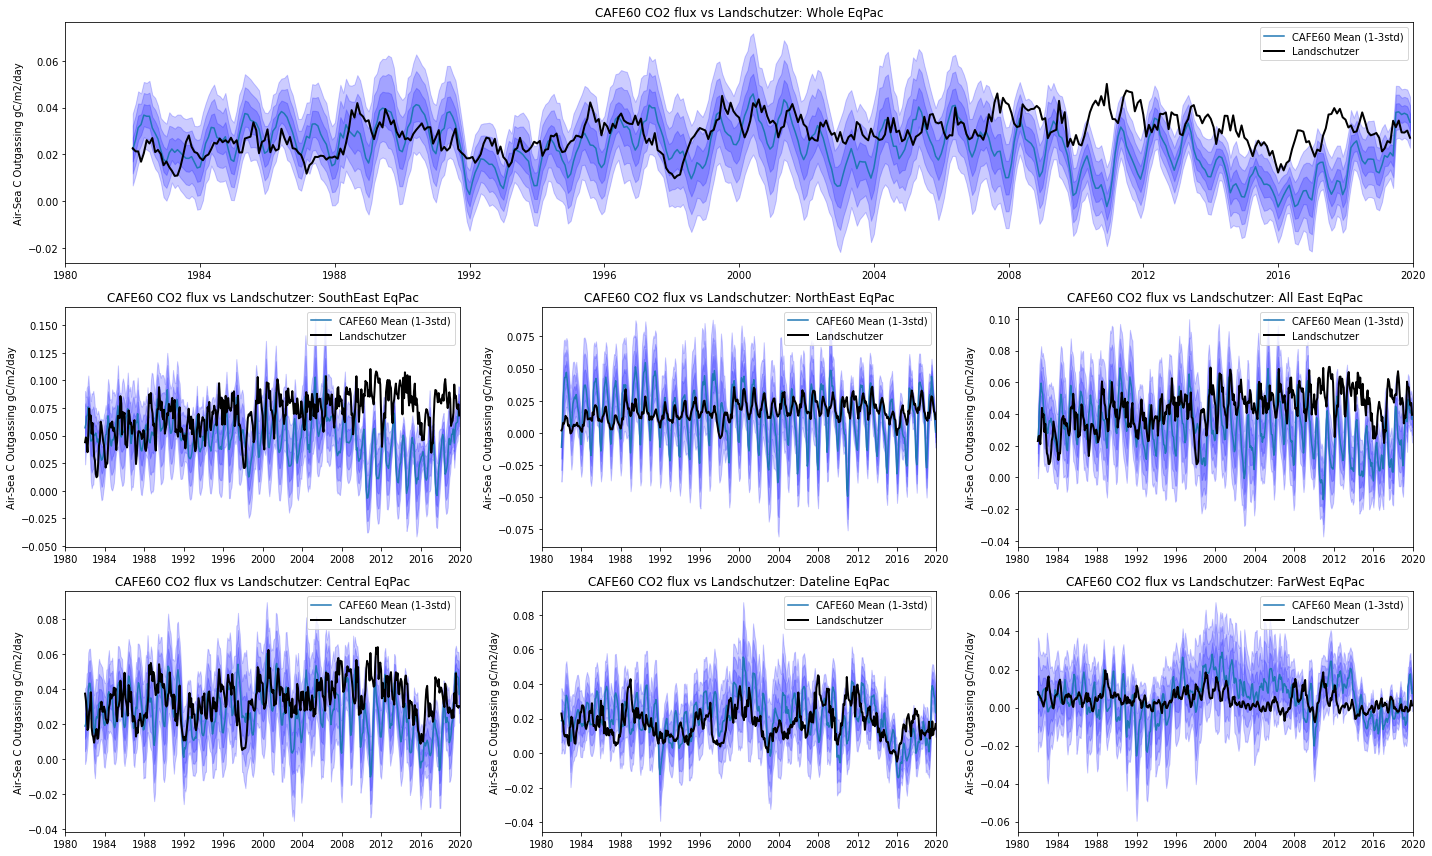

<xarray.Dataset>
Dimensions:      (ensemble: 96, region: 7)
Coordinates:
  * ensemble     (ensemble) int32 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
  * region       (region) int64 0 1 2 3 4 5 6
Data variables:
    percenterr   (region, ensemble) float64 9.666 6.69 -15.32 ... -354.4 -497.2
    bias         (region, ensemble) float64 0.001576 -7.235e-05 ... 0.003225
    mae          (region, ensemble) float64 0.009631 0.01025 ... 0.009204
    region_name  (region) <U15 'Whole EqPac' ... 'FarWest EqPac'


In [77]:
#Ok how does this error look through time for different parts of the Pacific.
labels=['Whole EqPac',
       'SouthEast EqPac',
       'NorthEast EqPac',
        'All East EqPac',
        'Central EqPac',
        'Dateline EqPac',
        'FarWest EqPac']

locs=[[-15,15,150,275],
      [-15,0,225,250],
      [0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,175,200],
      [-15,15,150,175]]
      
plt.figure(figsize=(20,12))

all_err=[]
for i,latlon in enumerate(locs):
    #Conversion  #mmol/s to mol/s to mol/day to g/day and also invert for sea-air flux
    cafe_co2_std_reg=(cafe_co2_all).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    cafe_co2_mean_reg=(cafe_co2_all).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    
    land_co2_std_reg=((land_co2.fgco2_smoothed)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    land_co2_mean_reg=((land_co2.fgco2_smoothed)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    
    print('cafe Co2 flux: '+ str(cafe_co2_mean_reg.mean(dim=['time','ensemble']).stf10.values))
    print('land co2 flux: '+str(land_co2_mean_reg.mean(dim=['time']).values))
    
    err=cafe_co2_mean_reg.std(dim='ensemble')
    m=cafe_co2_mean_reg.mean(dim='ensemble')
    
    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
    ax.plot(m.time,m.stf10)
    ax.fill_between(err.time.values,m.stf10+(err*1).stf10,m.stf10-(err*1).stf10,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.stf10+(err*2).stf10,m.stf10-(err*2).stf10,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.stf10+(err*3).stf10,m.stf10-(err*3).stf10,alpha=0.2,color='blue')

    ax.plot(land_co2_mean_reg.time,land_co2_mean_reg,c='k',linewidth=2)
    ax.legend(['CAFE60 Mean (1-3std)','Landschutzer'])
    ax.set_xlim(['1980-01-01','2020-01-01'])
    ax.set_ylabel('Air-Sea C Outgassing gC/m2/day')
    #ax.set_title('CO2 flux comparisons')
    ax.set_title('CAFE60 CO2 flux vs Landschutzer: '+labels[i])

    
    #Calculate biases
    
    #These biases might be backwards.
    perc_err=(((cafe_co2_mean_reg.stf10-land_co2_mean_reg)/land_co2_mean_reg)*100).mean(dim='time')
    bias=(cafe_co2_mean_reg.stf10-land_co2_mean_reg).mean(dim='time')
    mae=np.abs(cafe_co2_mean_reg.stf10-land_co2_mean_reg).mean(dim='time')
    print(labels[i]+' : '+str(perc_err.mean(dim='ensemble').values) + '% err')
    perc_err.name='percenterr'
    bias.name='bias'
    mae.name='mae'
    err_stats=xr.merge([perc_err,bias,mae],compat='override')
    err_stats['region']=i
    err_stats['region_name']=labels[i]
    all_err.append(err_stats)
    
regional_err=xr.concat(all_err,dim='region')

#Where do we want to save results??
#regional_err.to_netcdf('/scratch1/pit071/CO2_flux_error.nc')
plt.tight_layout()
plt.show()
print(regional_err)

## Lets look at and compare model CO2 flux to Landshutzer (seasonal)

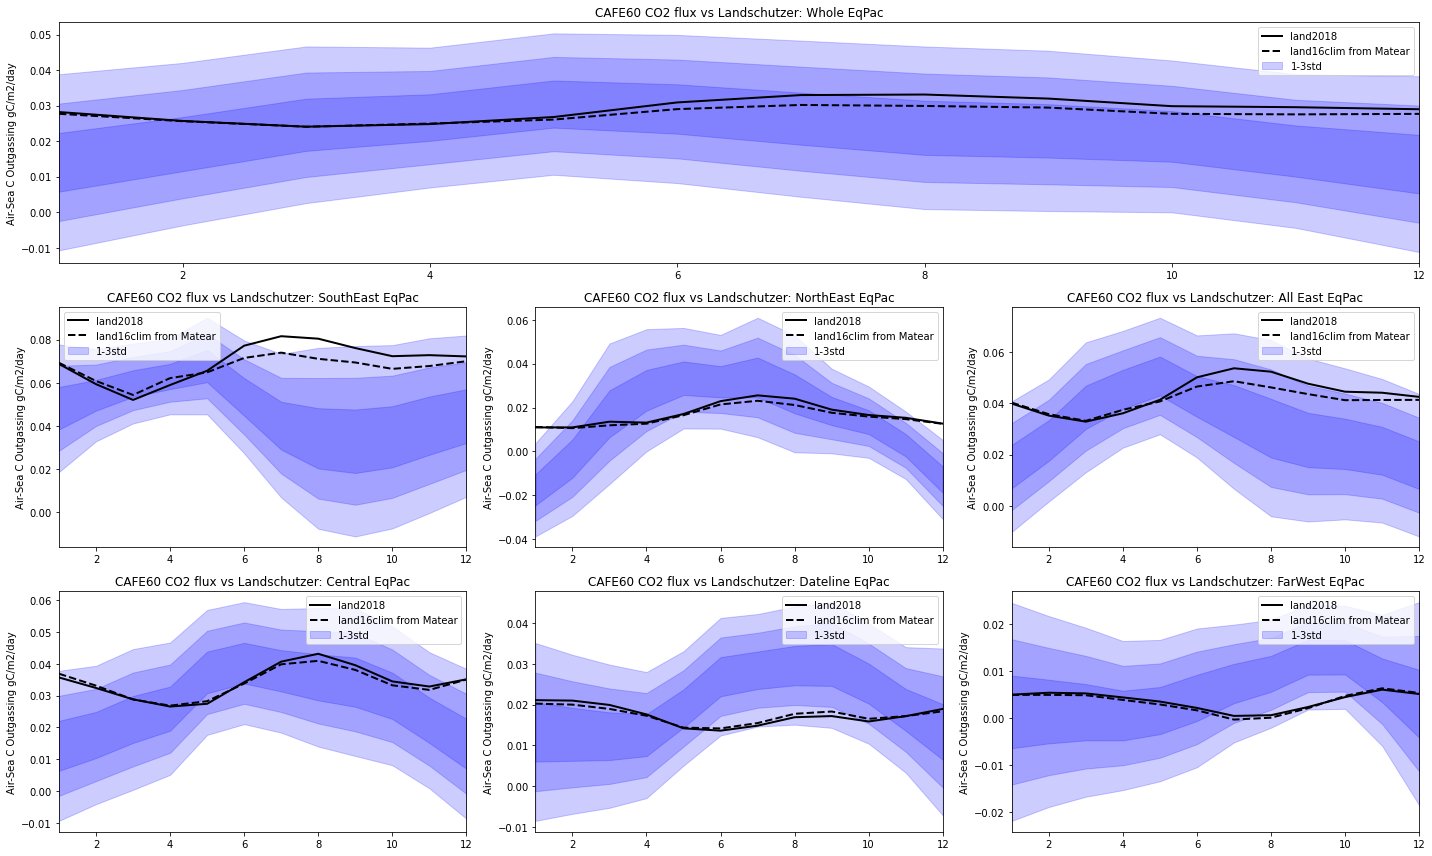

In [52]:
#They don't line up very well so lets check the seasonality
clim=xr.open_dataset('/scratch1/pit071/CAFE60/processed/obs/landshutzermatear_clim_eqpac_regrid.nc').fgco2_clim/365
labels=['Whole EqPac',
       'SouthEast EqPac',
       'NorthEast EqPac',
        'All East EqPac',
        'Central EqPac',
        'Dateline EqPac',
        'FarWest EqPac']

locs=[[-15,15,150,275],
      [-15,0,225,250],
      [0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,175,200],
      [-15,15,150,175]]
      
plt.figure(figsize=(20,12))

for i,latlon in enumerate(locs):
    cafe_seasonality=cafe_co2_all.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).stf10.groupby('time.month').mean()
 
    land_seasonality=land_co2.fgco2_smoothed.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).groupby('time.month').mean().mean(dim=['lat','lon'])

    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
        
    err=cafe_seasonality.std(dim='ensemble').mean(dim=['lat','lon'])
    m=cafe_seasonality.mean(['lat','lon','ensemble'])
    
    ax.fill_between(err.month,m+(err*1),m-(err*1),alpha=0.2,color='blue')
    ax.fill_between(err.month,m+(err*2),m-(err*2),alpha=0.2,color='blue')
    ax.fill_between(err.month,m+(err*3),m-(err*3),alpha=0.2,color='blue')

    ax.plot(land_seasonality.month,land_seasonality,c='k',linewidth=2)
   
    olc=clim.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    olc['monthclim']=olc['monthclim']+1
    ax.plot(olc.monthclim,olc,c='k',linewidth=2,linestyle='--')
    
    
    #Ok we could plot the individual lines using seaborn. 
    
    #land_seasonality=land_seasonality.to_dataframe().reset_index()
    #seasonal=cafe_seasonality.stf10.mean(dim=['lat','lon']).to_dataframe().reset_index()
    #sns.lineplot(data=seasonal,x='month',y='stf10',hue='ensemble',ax=ax)#,hue='ensemble')
    #sns.lineplot(data=land_seasonality,x='month',y='fgco2_smoothed',color='k',linewidth=3,ax=ax)#,hue='ensemble')
        
    ax.set_xlim([1,12])
    ax.set_ylabel('Air-Sea C Outgassing gC/m2/day')
    ax.set_title('CAFE60 CO2 flux vs Landschutzer: '+labels[i])
    ax.legend(['land2018','land16clim from Matear','1-3std']) #,
plt.tight_layout()

## Lets use those biases that we created before

In [85]:
#These should be quite close.
print(((0.0224-0.028)/0.028)*100) #Values from mean land and cafe co2 flux whole eq.
regional_err.sel(region=0).percenterr.mean().values

-20.0


array(-17.82865166)

NameError: name 'regional_err' is not defined

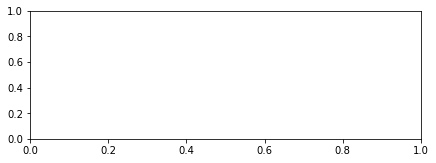

In [12]:
#Lets check the errors. 
plt.figure(figsize=(7,8))
plt.subplot(311)
regional_err.sel(region=0).percenterr.plot()
plt.title('CO2 flux Percent Error for each ensemble member')
plt.axhline(0,c='k')
plt.subplot(312)
regional_err.sel(region=0).bias.plot(c='b')
plt.axhline(0,c='k')
plt.title('CO2 flux Bias for each ensemble member')
plt.subplot(313)
regional_err.sel(region=0).mae.plot(c='r')
plt.axhline(0,c='k')
plt.title('CO2 flux MAE for each ensemble member')
plt.ylabel('co2 flux g/m2/day difference')

plt.tight_layout()

In [ ]:
#bias_ens=np.abs(bias).idxmin(dim='ensemble')
#rms_ens=rms.idxmin(dim='ensemble')

In [180]:
#Tells us the best perfming CO2 flux models are 46 for the whole pac and eastenr pacific, 64,48 and 1 in the central and west.
print(regional_err.percenterr.idxmin(dim='ensemble').values)
print(regional_err.region_name.values)

[47. 47. 47. 47. 64. 48.  1.]
['Whole EqPac' 'SouthEast EqPac' 'NorthEast EqPac' 'All East EqPac'
 'Central EqPac' 'Dateline EqPac' 'FarWest EqPac']


## Error

In [4]:
#Lets expand a bit further with calculating bias per pixel
#Calculate RMS and bias real quick... I say that but this might take a little while to process....  ()
#Might crash
# ------------------------------------------------
def calculate_co2_err():
    model=cafe_co2_all.stf10#.mean(dim=['time','ensemble'])
    obs=land_co2.fgco2_smoothed#.mean(dim='time')

    diff=model-obs
    diff_log=np.log10(model)-np.log10(obs)
    bias=10**(diff_log)
    perc_err=((model-obs)/obs)*100
    rms=np.sqrt(diff**2)
    mae=np.abs(diff)

    perc_err.name='perc_err'
    rms.name='rms'
    bias.name='bias'
    diff.name='difference'
    mae.name='mae'

    all_error=xr.merge([perc_err,rms,bias,diff,mae])
    print(all_error.nbytes/1e9)
    all_error.to_netcdf('/scratch1/pit071/CAFE60/processed/eqpac/CO2_flux_allerror.nc')
    return True
#Combine these into a dataset and save? WHere are we saving the results?! Lets make some folders.
def mean_co2_err():
    err=xr.open_dataset('/scratch1/pit071/CAFE60/processed/eqpac/CO2_flux_allerror.nc')
    err_tmean=err.mean(dim='time')
    err_tmean.to_netcdf('/scratch1/pit071/CAFE60/processed/eqpac/CO2_flux_meanerror.nc')

In [4]:
#calculate_co2_err()
#mean_co2_err()

/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/datastore/pit071/miniconda3/envs/pangeo/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [6]:
err_tmean=xr.open_dataset('/scratch1/pit071/CAFE60/processed/eqpac/CO2_flux_meanerror.nc')

In [7]:
# OK need to think more about how to plot all this.

KeyboardInterrupt: 

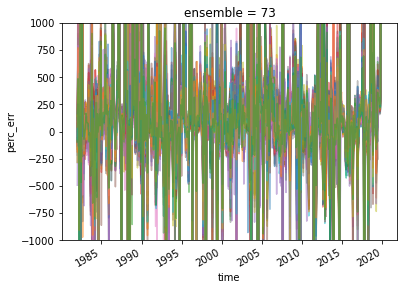

In [31]:
for i in err.ensemble:
    #print(i.values)
    model=err.sel(ensemble=i)
    model.perc_err.mean(dim=['lat','lon']).plot(alpha=0.5)
    plt.ylim([-1000,1000])

## Same again but for SST 

In [ ]:
titles=[
    'CAFE SST Ensemble Mean',
    'Reynolds OISST Mean',
    'CAFE SST Ensemble Mean 1982-2020 trend',
    'Reynolds OISST 1982-2020 trend',
    'CAFE SST Ensemble Mean 1982-2020 trend',
    'Reynolds OISST 2000-2020 trend']

mean_trends_82_20(cafe_sst_mean.sst,cafe_sst_82tr.trend,cafe_sst_20tr.trend,rey_sst.sst,rey_sst_82tr.trend,rey_sst_20tr.trend,titles,[-0.15,0.15],[-0.15,0.15],[0,32],[0,32],1,1,'viridis')

Text(0, 0.5, 'lat')

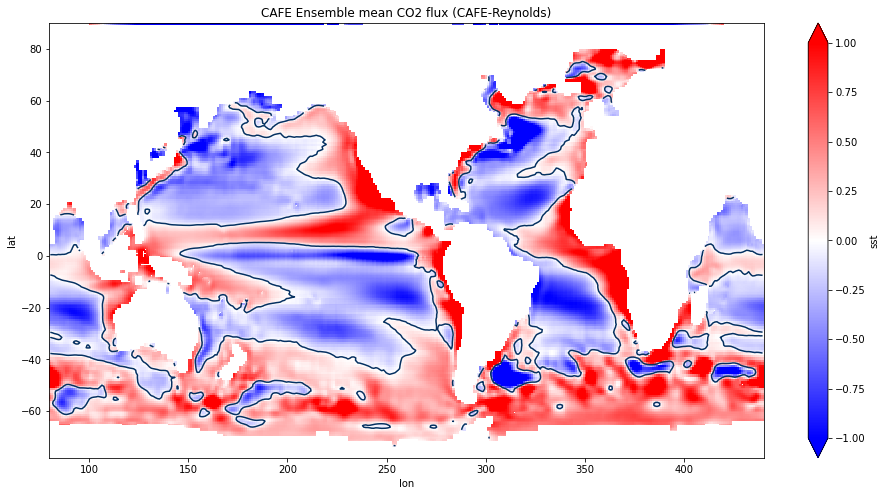

In [11]:
#Look at the difference between ensemble 1 and landschutzer
plt.figure(figsize=(16,8))
((cafe_sst_mean.sst.mean(dim='time'))-rey_sst.sst.mean(dim='time')).plot(vmin=-1,vmax=1,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
((cafe_sst_mean.sst.mean(dim='time'))-rey_sst.sst.mean(dim='time')).plot.contour(levels=[0])
                                                                                                 
plt.title('CAFE Ensemble mean CO2 flux (CAFE-Reynolds)')
plt.ylabel('lat')

#plt.subplot(212)
#(sst_cafe.mean(dim=['time','ensemble'])-sst_obs.mean(dim='time')).plot(vmin=-1.5,vmax=1.5,cmap='bwr')#(vmin=-0.15,vmax=0.15,cmap='bwr')
#(sst_cafe.mean(dim=['time','ensemble'])-sst_obs.mean(dim='time')).plot.contour(levels=[0])
#plt.title('Mean CAFE SST anomoly (CAFE-Reynolds)')
#plt.ylabel('Lat')
#plt.tight_layout()

In [13]:
cafe_sst_all

<xarray.Dataset>
Dimensions:   (ensemble: 96, lat: 98, lon: 170, time: 456)
Coordinates:
  * ensemble  (ensemble) int32 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * time      (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
Data variables:
    sst       (time, ensemble, lat, lon) float32 ...

In [ ]:
#Ok how does this error look through time for different parts of the Pacific.
labels=['Whole EqPac',
       'SouthEast EqPac',
       'NorthEast EqPac',
        'All East EqPac',
        'Central EqPac',
        'Dateline EqPac',
        'FarWest EqPac']

locs=[[-15,15,150,275],
      [-15,0,225,250],
      [0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,175,200],
      [-15,15,150,175]]
      
plt.figure(figsize=(20,12))

all_err=[]
for i,latlon in enumerate(locs):
    #Conversion  #mmol/s to mol/s to mol/day to g/day and also invert for sea-air flux
    cafe_co2_std_reg=(cafe_sst_all).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    cafe_co2_mean_reg=(cafe_sst_all).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    
    land_co2_std_reg=((rey_sst.sst)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).std(dim=['lat','lon'])
    land_co2_mean_reg=((rey_sst.sst)).sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).mean(dim=['lat','lon'])
    
    print('cafe SST: '+ str(cafe_co2_mean_reg.mean(dim=['time','ensemble']).sst.values))
    print('reynolds SST: '+str(land_co2_mean_reg.mean(dim=['time']).values))
    
    err=cafe_co2_mean_reg.std(dim='ensemble')
    m=cafe_co2_mean_reg.mean(dim='ensemble')
    
    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
    ax.plot(m.time,m.sst)
    ax.fill_between(err.time.values,m.sst+(err*1).sst,m.sst-(err*1).sst,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.sst+(err*2).sst,m.sst-(err*2).sst,alpha=0.2,color='blue')
    ax.fill_between(err.time.values,m.sst+(err*3).sst,m.sst-(err*3).sst,alpha=0.2,color='blue')

    ax.plot(land_co2_mean_reg.time,land_co2_mean_reg,c='k',linewidth=2)
    ax.legend(['CAFE60 SST Mean (1-3std)','Reynolds'])
    ax.set_xlim(['1980-01-01','2020-01-01'])
    ax.set_ylabel('SST')
    #ax.set_title('CO2 flux comparisons')
    ax.set_title('CAFE60 SST vs Reynolds: '+labels[i])

    
    #Calculate biases
    
    #These biases might be backwards.
    perc_err=(((cafe_co2_mean_reg.sst-land_co2_mean_reg)/land_co2_mean_reg)*100).mean(dim='time')
    bias=(cafe_co2_mean_reg.sst-land_co2_mean_reg).mean(dim='time')
    mae=np.abs(cafe_co2_mean_reg.sst-land_co2_mean_reg).mean(dim='time')
    print(labels[i]+' : '+str(perc_err.mean(dim='ensemble').values) + '% err')
    perc_err.name='percenterr'
    bias.name='bias'
    mae.name='mae'
    err_stats=xr.merge([perc_err,bias,mae],compat='override')
    err_stats['region']=i
    err_stats['region_name']=labels[i]
    all_err.append(err_stats)
    
regional_sst_err=xr.concat(all_err,dim='region')

#Where do we want to save results??
#regional_err.to_netcdf('/scratch1/pit071/CO2_flux_error.nc')
plt.tight_layout()
plt.show()
print(regional_sst_err)

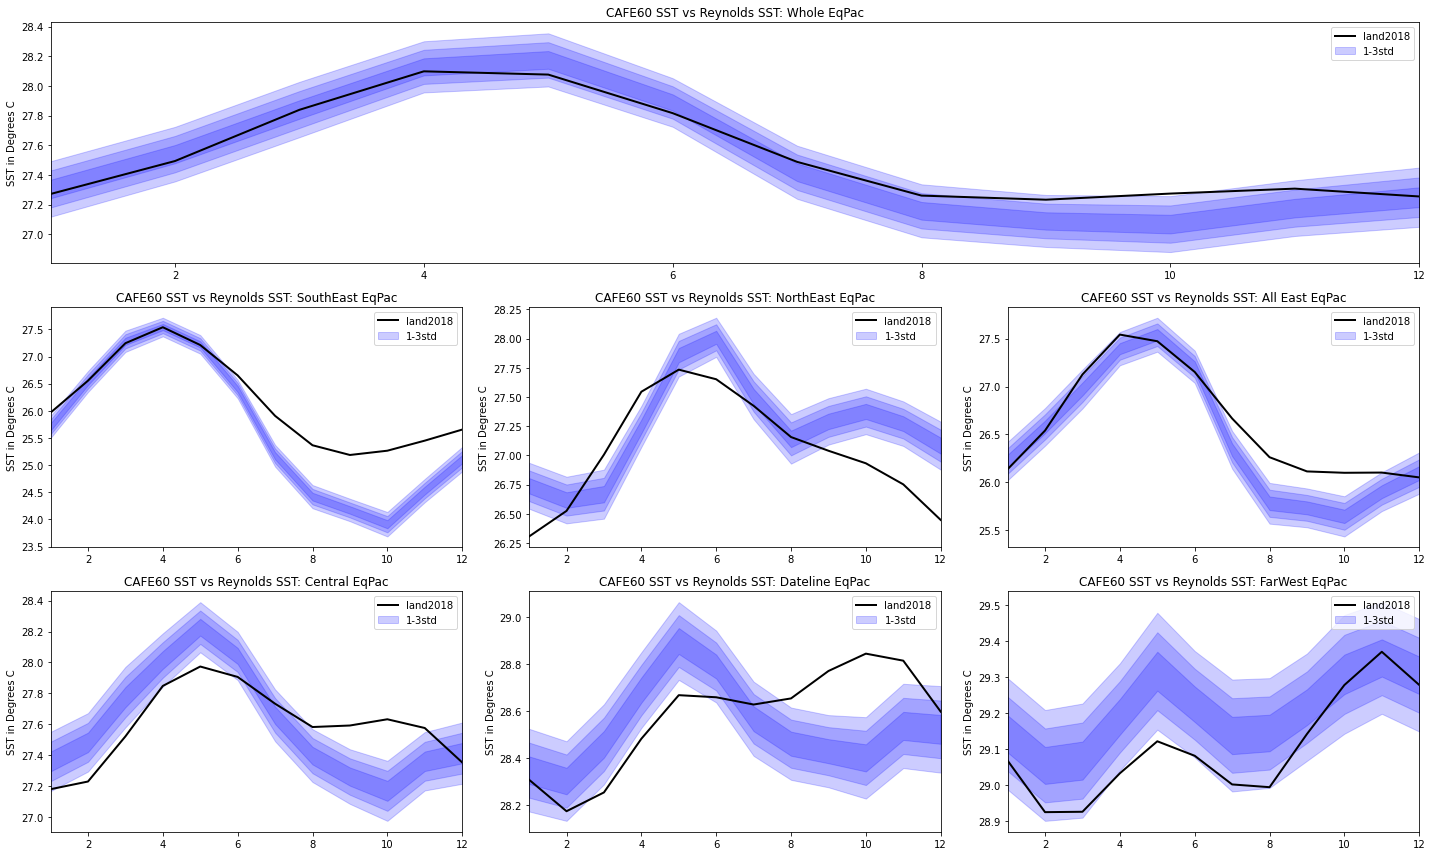

In [22]:
#They don't line up very well so lets check the seasonality for SST

labels=['Whole EqPac',
       'SouthEast EqPac',
       'NorthEast EqPac',
        'All East EqPac',
        'Central EqPac',
        'Dateline EqPac',
        'FarWest EqPac']

locs=[[-15,15,150,275],
      [-15,0,225,250],
      [0,15,225,250],
      [-15,15,225,250],
      [-15,15,200,225],
      [-15,15,175,200],
      [-15,15,150,175]]
      
plt.figure(figsize=(20,12))

for i,latlon in enumerate(locs):
    cafe_seasonality=cafe_sst_all.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).sst.groupby('time.month').mean()
 
    land_seasonality=rey_sst.sst.sel(lat=slice(latlon[0],latlon[1]),lon=slice(latlon[2],latlon[3])).groupby('time.month').mean().mean(dim=['lat','lon'])

    if i==0:
        ax=plt.subplot(3,1,1)
    else:
        ax=plt.subplot(3,3,3+i)
        
    err=cafe_seasonality.std(dim='ensemble').mean(dim=['lat','lon'])
    m=cafe_seasonality.mean(['lat','lon','ensemble'])
    
    ax.fill_between(err.month,m+(err*1),m-(err*1),alpha=0.2,color='blue')
    ax.fill_between(err.month,m+(err*2),m-(err*2),alpha=0.2,color='blue')
    ax.fill_between(err.month,m+(err*3),m-(err*3),alpha=0.2,color='blue')

    ax.plot(land_seasonality.month,land_seasonality,c='k',linewidth=2)
    
    #Ok we could plot the individual lines using seaborn. 
    
    #land_seasonality=land_seasonality.to_dataframe().reset_index()
    #seasonal=cafe_seasonality.stf10.mean(dim=['lat','lon']).to_dataframe().reset_index()
    #sns.lineplot(data=seasonal,x='month',y='stf10',hue='ensemble',ax=ax)#,hue='ensemble')
    #sns.lineplot(data=land_seasonality,x='month',y='fgco2_smoothed',color='k',linewidth=3,ax=ax)#,hue='ensemble')
        
    ax.set_xlim([1,12])
    ax.set_ylabel('SST in Degrees C')
    ax.set_title('CAFE60 SST vs Reynolds SST: '+labels[i])
    ax.legend(['land2018','1-3std']) #,
plt.tight_layout()

In [ ]:
#

In [26]:
### Check the SST error

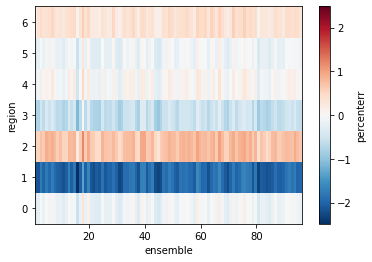

In [29]:
regional_sst_err.percenterr.plot()